In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# %load_ext line_profiler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Setup the models

In [2]:
from lotka_volterra_model import LotkaVolterraModel
from gene_toggle_model import GeneToggleModel

from model_data import ModelData
        
all_model_data = []
initial_distributions = []

########################
# Lokta-Volterra model
########################

all_model_data.append(ModelData(LotkaVolterraModel(),
                                ['A', 'B'],
                                0.1,
                                'Lotka-Volterra'))
initial_distributions.append({(300, 100): 1.})

########################
# Gene toggle model
########################
all_model_data.append(ModelData(GeneToggleModel(),
                                ['A', 'B'],
                                0.25,
                                'Toggle'))
initial_distributions.append({(1, 1): 1.})

# Run the stochastic simulations

In [3]:
from tqdm import tnrange, tqdm_notebook
from run_sim import run_sim

repeats = 5*10**5
# np.random.seed(1)

stoch_sim_data = {}

def get_data(model_data, init_dist):
    #run simulations
    state_paths = []

    if len(init_dist) > 1:
        print('error: only point mass initial distributions are supported')
        return
    
    x0 = np.array(list(init_dist.keys())[0])

    final = np.zeros(len(model_data.species))
    for i in tnrange(repeats, desc='Running simulations'):
        state_path, _ = run_sim(model_data.model, x0, model_data.t)
        final += state_path[-1,1:]
        state_paths.append(state_path)

    true_expected_x = final / float(repeats)

    data = pd.DataFrame(np.concatenate(state_paths)[:,1:], columns=model_data.species, dtype='int')
    data = data.groupby(model_data.species).size().reset_index(name='counts')
    return (data, state_paths)

for model_data, init_dist in zip(all_model_data, initial_distributions):
    print(model_data.model_name)
    stoch_sim_data[model_data.model_name] = get_data(model_data, init_dist)

Lotka-Volterra



Toggle


# Make the plots comparing the stochastic simulations to the support

support size: 3826
prob. lost: 0.643312
0.6436368470910145


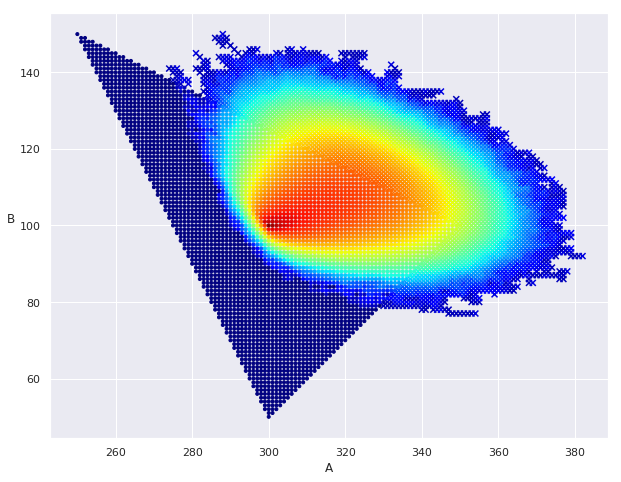

-------------------------
support size: 3753
prob. lost: 0.001526
0.0015835650453624886


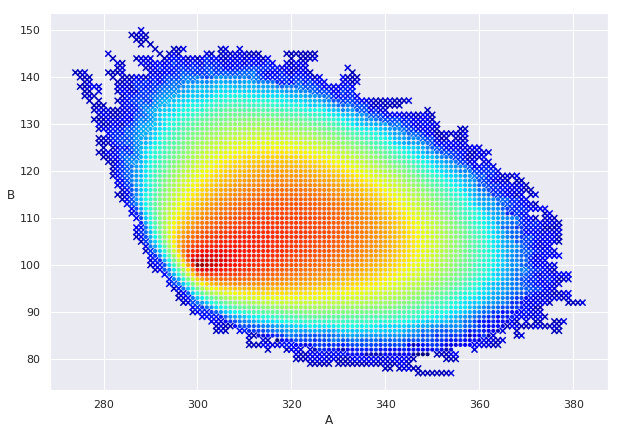

-------------------------
support size: 272
prob. lost: 0.000276
0.0002531382403602636


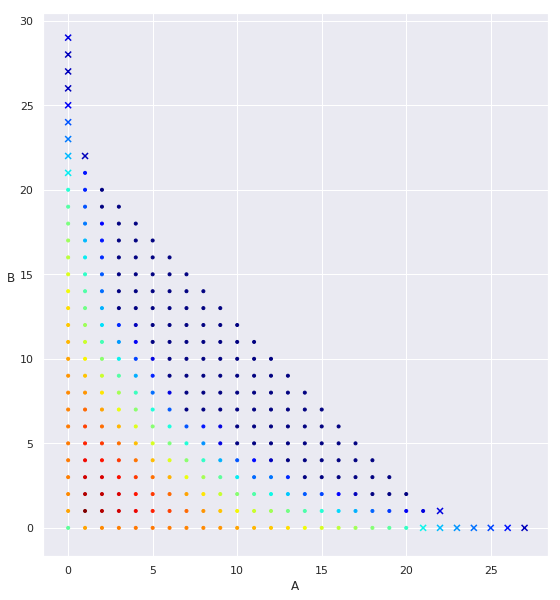

-------------------------
support size: 347
prob. lost: 0.001874
0.0017550879947691312


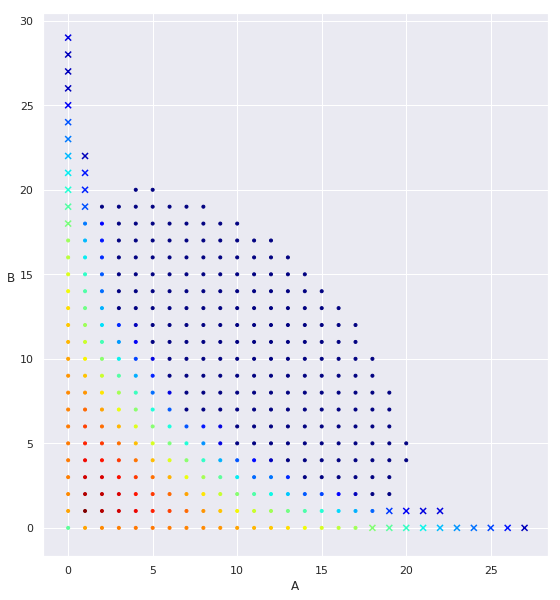

-------------------------


In [4]:
import seaborn as sns
import matplotlib.colors as colors
import gorde
import branch_and_prune
import r_step_reachability
from model_data import ModelData

#TODO remove
from get_generator import get_generator
from scipy.sparse.linalg import expm_multiply

def make_support_plot(support_algo, model_data, init_dist, param):
    raw_data, state_paths = stoch_sim_data[model_data.model_name]
    
    res = support_algo(model_data, init_dist, param)
    
    if type(res) is tuple:
        support = res[0]
    else:
        support = res

    #for each state visited by a path, determine if it's in the support
    support_memberships = raw_data.groupby(model_data.species)[model_data.species].apply(lambda x: tuple(x.values.flatten()) in support).reset_index(name='in_support')
    data = raw_data.merge(support_memberships)

    #support_df is just for plotting
    support_df = pd.DataFrame(list(support), columns=model_data.species)
    support_df = support_df.merge(raw_data, on=model_data.species, how='left').fillna(0)

    def compute_prob_lost():
        number_exited = 0.0
        for path in state_paths:
            path_states = set(map(tuple, path[:,1:]))
            #print(path_states - support)
            if not path_states.issubset(support):
                number_exited += 1.0
        return number_exited / float(len(state_paths))

    print('support size: {}'.format(len(support)))
    print('prob. lost: {}'.format(compute_prob_lost()))        
    
    generator, initial_dist, index_to_state = get_generator(model_data, init_dist, support)
    dist = expm_multiply(generator * model_data.t, initial_dist)
    print(dist[0])
    
    #print(data.head())

    #for the purposes of plotting, combine rows with the same counts for A and B,
    #basically we are computing the marginals
    marginal_support_df = support_df.groupby(['A', 'B'])['counts'].sum().reset_index()

    outside_support_subset = data.iloc[~data['in_support'].values,:]
    #thing = outside_support_subset.groupby(['A', 'B'])['counts'].sum().reset_index()
    sns.set()

    #the counts vary dramatically, so taking the log makes for a better visualization
    color_norm = colors.LogNorm(vmin=data['counts'].min(), vmax=data['counts'].max())

    outside_support_subset = data.iloc[~data['in_support'].values,:]
    plt.scatter(x=outside_support_subset['A'],
                y=outside_support_subset['B'],
                c=outside_support_subset['counts'] + 1,
                marker='x',
                norm=color_norm,
                cmap='jet')

    #plot this second
    plt.scatter(x=marginal_support_df['A'],
                y=marginal_support_df['B'],
                c=marginal_support_df['counts'] + 1, #add 1 because counts might be zero
                marker='.',
                norm=color_norm,
                cmap='jet')
    
    plt.xlabel('A')
    plt.ylabel('B', rotation=0, ha='right')
#     plt.title('Model: {}, Support size: {}'.format(model_data.model_name, len(support)))

    #plot the 'expected path'
#     dx = expected_final_x - x0
#     plt.arrow(x0[0], x0[1], dx[0], dx[1],
#               width=0.1,
#               head_width=0.5,
#               color='black')

    plt.gcf().set_size_inches(10, 10)
    plt.gca().set_aspect('equal')
    
    plt.savefig('{}_{}.eps'.format(model_data.model_name, support_algo.__module__),
                format='eps',
                dpi=1000,
                bbox_inches='tight')
    plt.show()
    
    
    print('-------------------------')

####################################################

reachability_params = {'Lotka-Volterra': 50, 'Toggle': 20}
branch_and_prune_params = {'Lotka-Volterra': 10**(-6), 'Toggle': 10**(-7)}

for model_data, init_dist in zip(all_model_data, initial_distributions):
    make_support_plot(r_step_reachability.get_support, model_data, init_dist, reachability_params[model_data.model_name])
    make_support_plot(branch_and_prune.get_support, model_data, init_dist, branch_and_prune_params[model_data.model_name])